In [1]:
import numpy as np
import json
import torch
from torch import optim
from lib.defaults import Main
from lib.gramians import Make
from lib.dynamics_diff import Dynamics
from lib.simple import Sim
from lib.controller import dynamic, decompose
import matplotlib.pyplot as plt
from lib.plotting import set_figure, plot_fr_per_cond, plot_out
import sys

In [2]:
# params I need 
main = Main()
tau_z, tau_y = main.taus                   
a = main.a
G = Make(a)
r2 = main.r2_dynamic
pmd_slice = main.pmd_slice
relu = torch.nn.ReLU()
# setup_base
target = torch.load("./torque.pt")  #(c,2,t)
n_mov = len(target)
n_muscles, n_bins = np.array(target[0]).shape # n_muscles=2
xstars_std = 0.2
t_max = main.sampling_dt * n_bins

# prms
n = main.n
n_obs = n
n_e = main.n_e
lambda_traj = 1.0 / n_mov
lambda_reg = 1.0 / (len(main.m1_slice) * n_muscles)

gamma_ = torch.Tensor(main.gamma)
reuse = True

In [3]:
spontaneous = np.loadtxt('spontaneous.txt')
with open('setup_prms.json') as f:
    prms = json.load(f)
c = np.array(prms['c'])

# generate xstars
xstars_prms0 = np.random.normal(scale=0.1 / np.sqrt(n), size=(n_obs, n_mov))
# torch
xstars_p_tch = torch.Tensor(xstars_prms0).requires_grad_(True)
c_p_tch = torch.Tensor(c)
cgamma = c_p_tch @ gamma_  
spontaneous_ = torch.Tensor(spontaneous[:,None])

In [4]:
c_p_tch.shape, gamma_.shape, spontaneous_.shape

(torch.Size([2, 160]), torch.Size([160, 200]), torch.Size([200, 1]))

In [5]:
def projection(cgamma_top_obs):
    # used to make sure that xstars stay in the null space of fixed c 
    e = torch.eye(n_obs) 
    h = torch.linalg.solve(cgamma_top_obs @ cgamma_top_obs.T, cgamma_top_obs)    
    return e - cgamma_top_obs.T @ h


def unpack(xstars_prms, c):
    # xstars_prms: n_obs * n_mov
    # c_prms: n_muscles * n_m1
    top_obs = torch.Tensor(G.O.top(n_obs))
    cgamma_top_obs = cgamma @ top_obs
    proj = projection(cgamma_top_obs)
    
    z = n * n_mov * xstars_std ** 2

    xstars = top_obs @ proj @ xstars_prms
    xstars = torch.sqrt(z / torch.sum(xstars ** 2)) * xstars 
    return spontaneous_ + xstars


In [6]:
if reuse:
    with open('loop_prms.json') as f:
        prms = json.load(f)
    xz = torch.from_numpy(np.array(prms['xz'])).float()
    zy = torch.from_numpy(np.array(prms['zy'])).float()
    yx = torch.from_numpy(np.array(prms['yx'])).float()
else:
    q = Sim().q_mov(c) 
    yx_xy = dynamic(a, pmd_slice, main.n_e, main.tau, main.taus, r2, q) # very slow
    n_z = n
    xz, zy, yx = decompose(n, n_z, pmd_slice, yx_xy, reg=0.1)

In [7]:
# Trajectory
def trajectory(xstars): 
    # layer
    def layers_func(xstars):                 
        y0 = yx @ relu(xstars)
        z0 = relu(zy @ relu(y0)) 
        # torch  
        return ((tau_z, xz, z0), (tau_y, zy, y0))
    
    layers = layers_func(xstars)
    r = Dynamics().run(t_max, xstars, spontaneous_, grad = True, layers = layers)   
#     r = Dynamics().run(t_max, xstars, spontaneous_, grad = True, layers = None) 
    
    r = torch.stack(r, dim=0)  
    out = [cgamma @ r[:,:,i].T for i in range(n_mov)]
    out = torch.stack(out, dim=0) 
    return r, out

def loss(torq, target):
    cost_move = lambda_traj * main.sampling_dt * ((torq - target)**2).sum()
    return cost_move

 iteration 400/400 | train loss: 0.00824

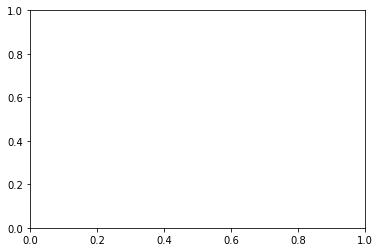

In [8]:
n_iter = 400     
updater = optim.Adam([xstars_p_tch])  
total_loss_for_plotting = np.empty(0)

for it in range(n_iter):          
    xstars = unpack(xstars_p_tch, c_p_tch)
    _, torq = trajectory(xstars)        
    l = loss(torq, target)
    total_loss_for_plotting = np.append(total_loss_for_plotting, l.item())
    updater.zero_grad()
    l.backward()
    updater.step()
    sys.stdout.write(f'\r iteration {it+1}/{n_iter} | train loss: {l.item():.5f}')
    sys.stdout.flush()
    plt.plot(total_loss_for_plotting)
    plt.title('The loss is %.5f of iteration %d'%(l.item(),it))
    plt.savefig('log/loss_setup_dynamics.png')
    plt.clf()  
    plt.cla()      
#     you can save every 100 inter
#     if (it+1)%100 == 0 :
#         torch.save(...)    

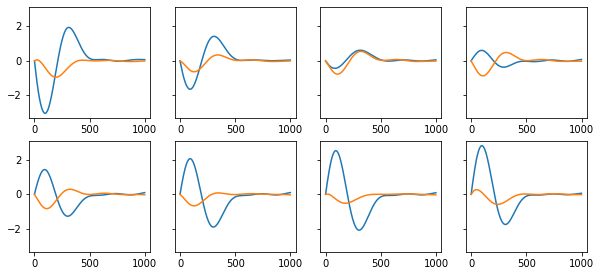

In [12]:
_, torque = trajectory(xstars)  
plot_out(torque.detach().numpy())

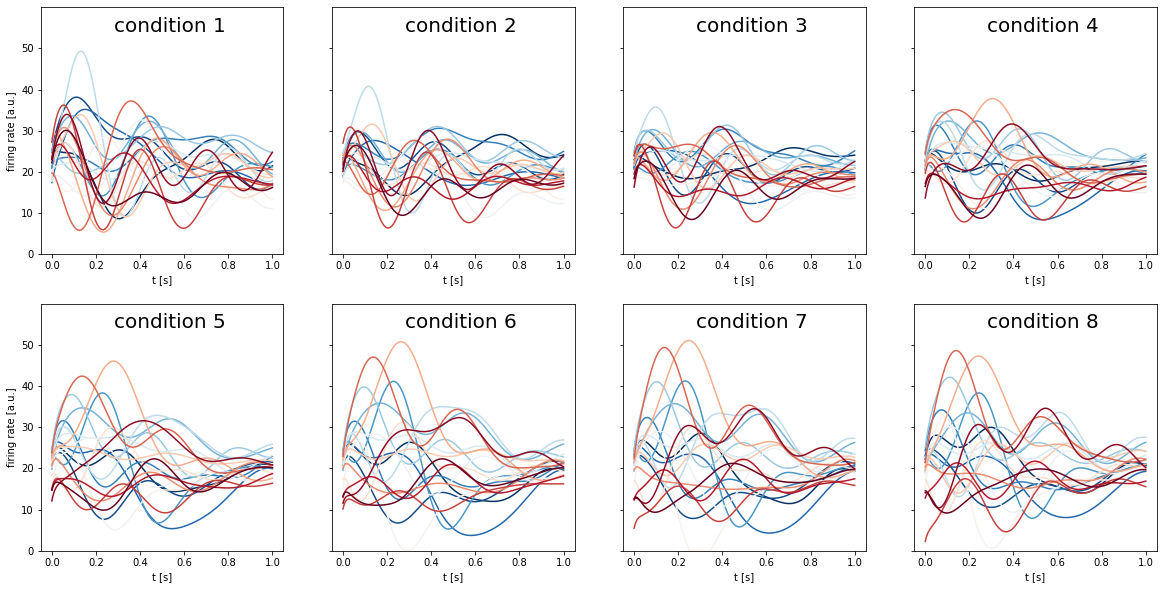

In [13]:
t_move = 1
spontaneous = spontaneous_.detach().numpy()
# xstars = xstars.detach().numpy()
r = np.array(Dynamics().run(t_move, xstars.detach().numpy(), spontaneous))
axes = set_figure(n_mov)    
for j in range(n_mov):
    plot_fr_per_cond(axes, j, t_move,20*r[:,:,j], xstars)   

In [14]:
loop = {
        'xz': xz.tolist(),
        'zy': zy.tolist(),
        'yx': yx.tolist()
}
with open("loop_prms.json","w", encoding='utf-8') as f: 
    f.write(  json.dumps(  loop  ,ensure_ascii=False  ) )  
    
    
prms = {
        'xstars': xstars.detach().numpy().tolist(),
        'c': c.tolist()
}
with open("setup_prms_dynamics.json","w", encoding='utf-8') as f: 
    f.write(  json.dumps(  prms  ,ensure_ascii=False  ) )  
